<a href="https://colab.research.google.com/github/ariorzk/sibi-coral/blob/main/sibi_recognition_mobilenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SIBI Alphabet Classifier for Edge TPU

This notebook contains the code to train Machine Learning model to recognize Sistem Isyarat Bahasa Indonesia (SIBI) or Indonesian sign language. The model is limited to only recognizing static alphabet of SIBI and not other kind of sign such as words, phrases, or numbers.

## Importing the dataset

For this purpose, I am using premade dataset from Kaggle titled 'Sistem Isyarat Bahasa Indonesia (SIBI)' by Alvin Bintang. This dataset contains 220 images for each static alphabets (everything except j and z) totaling 5280 images.

The codes below are intended for importing Kaggle dataset to Google Colab. If you have your own dataset or you're working on local machine with Jupyter Notebook or other applications, you can safely skip this section.

In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!mkdir ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download "alvinbintang/sibi-dataset"

 99% 2.68G/2.70G [00:19<00:00, 134MB/s]
100% 2.70G/2.70G [00:19<00:00, 148MB/s]


In [6]:
!unzip sibi-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: SIBI/B/1645946451.0243402_B.jpg  
  inflating: SIBI/B/1645946454.6260056_U.jpg  
  inflating: SIBI/B/1645946456.4885087_F.jpg  
  inflating: SIBI/B/1645946460.4972847_B.jpg  
  inflating: SIBI/B/1645946463.7729926_B.jpg  
  inflating: SIBI/B/1645946467.532869_B.jpg  
  inflating: SIBI/B/1645949132.0273714_B.jpg  
  inflating: SIBI/B/1645949136.465165_B.jpg  
  inflating: SIBI/B/1645949142.7455149_B.jpg  
  inflating: SIBI/B/1645949858.470701_Q.jpg  
  inflating: SIBI/B/1645949859.1649747_C.jpg  
  inflating: SIBI/B/1645949859.858002_Q.jpg  
  inflating: SIBI/B/1645949860.5160742_G.jpg  
  inflating: SIBI/B/1645949860.9303768_C.jpg  
  inflating: SIBI/B/1645949863.3891625_C.jpg  
  inflating: SIBI/B/1645949864.6113553_C.jpg  
  inflating: SIBI/B/1645950338.9793453_C.jpg  
  inflating: SIBI/B/1645950339.6984558_C.jpg  
  inflating: SIBI/B/1645950340.2939713_C.jpg  
  inflating: SIBI/B/1645950341.0949953_C.jpg  
  inflating: 

In [7]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import splitfolders

splitfolders.ratio('SIBI', output="output", seed=1337, ratio=(0.8, 0.1, 0.1)) 

Copying files: 5280 files [00:11, 446.58 files/s]


## Import the needed library

In [9]:
import tensorflow as tf
assert float(tf.__version__[:3]) >= 2.3

import numpy as np
import matplotlib.pyplot as plt

In [10]:
train_dir = '/content/output/train'
val_dir = '/content/output/val'
test_dir = '/content/output/test'

In [11]:
from keras.preprocessing.image import ImageDataGenerator
IMAGE_SIZE = 224
BATCH_SIZE = 32

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False)

Found 4224 images belonging to 24 classes.
Found 528 images belonging to 24 classes.
Found 528 images belonging to 24 classes.


In [12]:
image_batch, label_batch = next(val_generator)
image_batch.shape, label_batch.shape

((32, 224, 224, 3), (32, 24))

In [13]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('sibi_labels.txt', 'w') as f:
  f.write(labels)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'O': 13, 'P': 14, 'Q': 15, 'R': 16, 'S': 17, 'T': 18, 'U': 19, 'V': 20, 'W': 21, 'X': 22, 'Y': 23}


In [ ]:
! cat sibi_labels.txt

In [14]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained MobileNet V2
base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                                  include_top=False, 
                                                  weights='imagenet')
base_model.trainable = False

17225924/17225924 [==============================] - 0s 0us/step


In [15]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(units=24, activation='softmax')
])

In [16]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          294944    
                                                                 
 dropout (Dropout)           (None, 5, 5, 32)          0         
                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 24)                792       
                                                                 
Total params: 3,524,600
Trainable params: 295,736
Non-tr

In [18]:
print('Number of trainable weights = {}'.format(len(model.trainable_weights)))

Number of trainable weights = 4


In [19]:
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator), 
                    epochs=10,
                    validation_data=val_generator,
                    validation_steps=len(val_generator))

Epoch 1/10
132/132 [==============================] - 426s 3s/step - loss: 2.1165 - accuracy: 0.3565 - val_loss: 1.0837 - val_accuracy: 0.6837
Epoch 2/10
132/132 [==============================] - 416s 3s/step - loss: 0.6748 - accuracy: 0.8026 - val_loss: 0.4109 - val_accuracy: 0.8996
Epoch 3/10
132/132 [==============================] - 414s 3s/step - loss: 0.2993 - accuracy: 0.9098 - val_loss: 0.3480 - val_accuracy: 0.8958
Epoch 4/10
132/132 [==============================] - 413s 3s/step - loss: 0.1501 - accuracy: 0.9574 - val_loss: 0.1884 - val_accuracy: 0.9451
Epoch 5/10
132/132 [==============================] - 411s 3s/step - loss: 0.1125 - accuracy: 0.9714 - val_loss: 0.1720 - val_accuracy: 0.9413
Epoch 6/10
132/132 [==============================] - 419s 3s/step - loss: 0.0866 - accuracy: 0.9761 - val_loss: 0.1954 - val_accuracy: 0.9394
Epoch 7/10
132/132 [==============================] - 414s 3s/step - loss: 0.0614 - accuracy: 0.9825 - val_loss: 0.2010 - val_accuracy: 0.9337

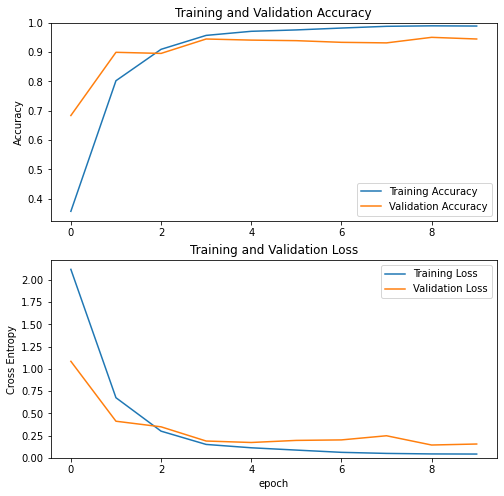

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [21]:
# A generator that provides a representative dataset
def representative_data_gen():
  dataset_list = tf.data.Dataset.list_files(train_dir + '/*/*')
  for i in range(100):
    image = next(iter(dataset_list))
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image / 255., tf.float32)
    image = tf.expand_dims(image, 0)
    yield [image]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
# This enables quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# This sets the representative dataset for quantization
converter.representative_dataset = representative_data_gen
# This ensures that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# For full integer quantization, though supported types defaults to int8 only, we explicitly declare it for clarity.
converter.target_spec.supported_types = [tf.int8]
# These set the input and output tensors to uint8 (added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model = converter.convert()

with open('mobilenet_1.0_224_quant_sibi.tflite', 'wb') as f:
  f.write(tflite_model)

/usr/local/lib/python3.8/dist-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [22]:
batch_images, batch_labels = next(val_generator)

logits = model(batch_images)
prediction = np.argmax(logits, axis=1)
truth = np.argmax(batch_labels, axis=1)

keras_accuracy = tf.keras.metrics.Accuracy()
keras_accuracy(prediction, truth)

print("Raw model accuracy: {:.3%}".format(keras_accuracy.result()))

Raw model accuracy: 96.875%


In [25]:
def set_input_tensor(interpreter, input):
  input_details = interpreter.get_input_details()[0]
  tensor_index = input_details['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  # Inputs for the TFLite model must be uint8, so we quantize our input data.
  # NOTE: This step is necessary only because we're receiving input data from
  # ImageDataGenerator, which rescaled all image data to float [0,1]. When using
  # bitmap inputs, they're already uint8 [0,255] so this can be replaced with:
  #   input_tensor[:, :] = input
  scale, zero_point = input_details['quantization']
  input_tensor[:, :] = np.uint8(input / scale + zero_point)

def classify_image(interpreter, input):
  set_input_tensor(interpreter, input)
  interpreter.invoke()
  output_details = interpreter.get_output_details()[0]
  output = interpreter.get_tensor(output_details['index'])
  # Outputs from the TFLite model are uint8, so we dequantize the results:
  scale, zero_point = output_details['quantization']
  output = scale * (output - zero_point)
  top_1 = np.argmax(output)
  return top_1

interpreter = tf.lite.Interpreter('mobilenet_1.0_224_quant_sibi.tflite')
interpreter.allocate_tensors()

# Collect all inference predictions in a list
batch_prediction = []
batch_truth = np.argmax(batch_labels, axis=1)

for i in range(len(batch_images)):
  prediction = classify_image(interpreter, batch_images[i])
  batch_prediction.append(prediction)

# Compare all predictions to the ground truth
tflite_accuracy = tf.keras.metrics.Accuracy()
tflite_accuracy(batch_prediction, batch_truth)
print("Quant TF Lite accuracy: {:.3%}".format(tflite_accuracy.result()))


Quant TF Lite accuracy: 81.250%


In [26]:
test = model.evaluate(test_generator)

17/17 [==============================] - 61s 4s/step - loss: 0.1155 - accuracy: 0.9602


In [27]:
pred = model.predict(test_generator)
pred = tf.nn.softmax(pred)

output = np.argmax(pred, axis=1)
labels = test_generator.class_indices
print(labels)
print(type(labels))

pred_labels = dict((v,k) for k,v in labels.items())
print(pred_labels)
print(type(pred_labels))

17/17 [==============================] - 59s 3s/step
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'O': 13, 'P': 14, 'Q': 15, 'R': 16, 'S': 17, 'T': 18, 'U': 19, 'V': 20, 'W': 21, 'X': 22, 'Y': 23}
<class 'dict'>
{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'K', 10: 'L', 11: 'M', 12: 'N', 13: 'O', 14: 'P', 15: 'Q', 16: 'R', 17: 'S', 18: 'T', 19: 'U', 20: 'V', 21: 'W', 22: 'X', 23: 'Y'}
<class 'dict'>


In [28]:
labeled_pred = []
for i in range(0, len(output)):
    labeled_pred.append(pred_labels[output[i]])

In [29]:
labeled_true = []
for i in range(0, len(test_generator.classes)):
    labeled_true.append(pred_labels[test_generator.classes[i]])

              precision    recall  f1-score   support

           A     0.9545    0.9545    0.9545        22
           B     0.8800    1.0000    0.9362        22
           C     1.0000    1.0000    1.0000        22
           D     1.0000    1.0000    1.0000        22
           E     0.9167    1.0000    0.9565        22
           F     1.0000    0.8182    0.9000        22
           G     1.0000    1.0000    1.0000        22
           H     1.0000    1.0000    1.0000        22
           I     0.9091    0.9091    0.9091        22
           K     0.9545    0.9545    0.9545        22
           L     0.9167    1.0000    0.9565        22
           M     0.8800    1.0000    0.9362        22
           N     1.0000    1.0000    1.0000        22
           O     1.0000    1.0000    1.0000        22
           P     1.0000    0.9091    0.9524        22
           Q     0.9565    1.0000    0.9778        22
           R     1.0000    0.9545    0.9767        22
           S     1.0000    

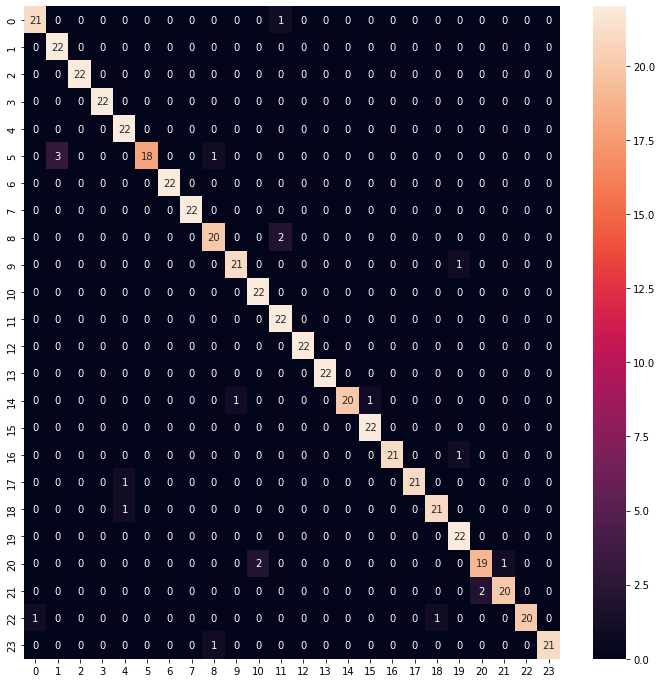

In [31]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print(classification_report(labeled_true,labeled_pred,digits=4))
cf_matrix = confusion_matrix(labeled_true, labeled_pred)

plt.figure(figsize=(12,12))
sns.heatmap(cf_matrix,annot=True)

In [32]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

! sudo apt-get update

! sudo apt-get install edgetpu-compiler	

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  27279      0 --:--:-- --:--:-- --:--:-- 27576
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:7 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease [6,722 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 h

In [33]:
! edgetpu_compiler mobilenet_1.0_224_quant_sibi.tflite

Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.

Model compiled successfully in 1515 ms.

Input model: mobilenet_1.0_224_quant_sibi.tflite
Input size: 3.64MiB
Output model: mobilenet_1.0_224_quant_sibi_edgetpu.tflite
Output size: 3.69MiB
On-chip memory used for caching model parameters: 3.86MiB
On-chip memory remaining for caching model parameters: 3.86MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 37
Operation log: mobilenet_1.0_224_quant_sibi_edgetpu.log
See the operation log file for individual operation details.
Compilation child process completed within timeout period.
Compilation succeeded! 


In [34]:
from google.colab import files

files.download('mobilenet_1.0_224_quant_sibi_edgetpu.tflite')
files.download('sibi_labels.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>